# RNN ile Havayolu Sayısı Tahmini

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evaluation)

### 1) İş Problemi (Business Problem)

- 1949 - 1960 yılları arasındaki aylık havayolu verileri

- **Month:** Aylık olarak yer alan tarih değişkenidir.
- **Passenger:** İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.

# 2) Veriyi Anlamak (Data Understanding)

### 2.1) Gerekli Kütüphanelerin Import İşlemleri

In [2]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler

import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.

import warnings
warnings.filterwarnings("ignore")

# Tensorflow Warning Engelleme

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### 2.2) Veri Setinin Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [119]:
df = pd.read_csv("international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [120]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [121]:
df.columns = ["Month", "Passengers"]

In [122]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [123]:
df.tail()  # son satırda problemli bir değişken var, müdahale edeceğiz.

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [124]:
df.shape

(145, 2)

In [125]:
df.dtypes  # Month'ın tipini değiştirmeliyiz.

Month          object
Passengers    float64
dtype: object

In [126]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [127]:
df.describe().T  

# ortalama ile medyan arasında pek fark yok o yüzden çok fazla çarpıklık yok.
# standart sapması 119 ve ortalaması 280. Demek ki çok değişkenli bir yapı var.

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


### 3) Veriyi Hazırlamak (Data Preparation)

In [128]:
df = df[:144] # Son satırdaki hatalı değişkeni attık.

In [129]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [130]:
df.info()  # Month değişkenini tarih değişkeni olarak değiştirelim.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [131]:
df["Month"] = pd.to_datetime(df["Month"])

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [133]:
print("Minimum Tarih: ", df["Month"].min())
print("Maksimum Tarih: ", df["Month"].max())

Minimum Tarih:  1949-01-01 00:00:00
Maksimum Tarih:  1960-12-01 00:00:00


In [134]:
df.index = df["Month"]
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [135]:
df.drop("Month", axis = 1, inplace = True)
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [136]:
result_df = df.copy()

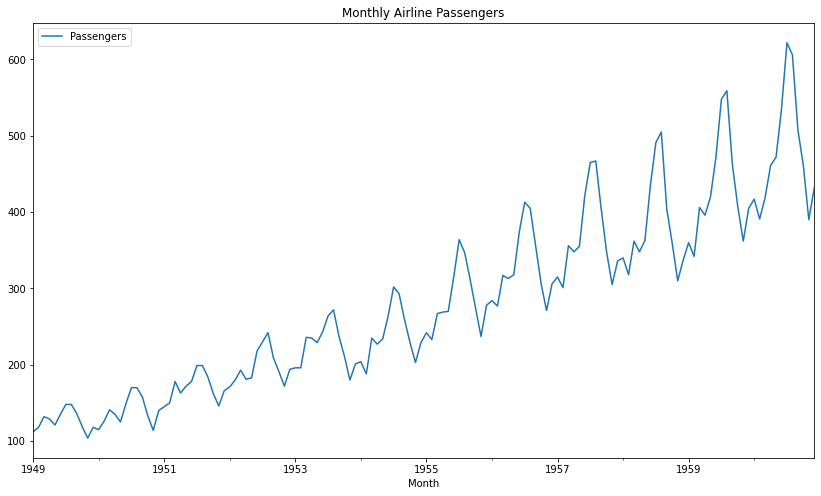

In [137]:
df.plot(figsize = (14,8), title = "Monthly Airline Passengers");

In [138]:
data = df["Passengers"].values  # Modele numpy array tipinde bilgi göndermek için Pandas'ı Numpy array yaptık.
data[0:5]

array([112., 118., 132., 129., 121.])

In [139]:
type(data[0:5])

numpy.ndarray

In [140]:
type(data[0])  # float64 tipini float32'ye çevireceğiz.  modelde yaygın kullanım budur.

numpy.float64

In [141]:
data = data.astype("float32")

In [142]:
type(data[0])

numpy.float32

In [143]:
data.shape

(144,)

In [144]:
data = data.reshape(-1,1)

In [145]:
data.shape

(144, 1)

### Model Kurulumu

Model serisi problemlerinde train - test ayrımı yapılırken scikitlearn kütüphanesini kullanamıyoruz. Çünkü scikitlearn train-test ayrımını rastgele yapıyor. Elimizeki veri seti zamana duyarlı olduğu için, sıralı olduğu için rastgele şekilde ayrımlar yapamayız. Aksi taktirde birbirleri ile olan bağı koparmış oluruz.

In [146]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe)*(1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [147]:
train, test, position = split_data(data, 0.33)
# train - test genelde 80'e 20 olarak ayrılmaktadır.
# ancak biz burada 0,67'ye 0,33 yaptık ki elimizdeki 144 adet veri 96 - 48 olarak ayrılsın.

In [148]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [149]:
# Gradient Descent yöntemi kullanılıyorsa encoding yapmak iyi olur.

In [150]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [151]:
train = scaler_train.fit_transform(train)

In [152]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [153]:
test = scaler_test.fit_transform(test)

In [154]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [155]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [156]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
        
        return np.array(X), np.array(Y)

In [157]:
lookback = 1

In [158]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

In [159]:
# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [160]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1, 1) (1,) (1, 1) (1,)


In [161]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# RNN'in bizden istemiş olduğu format. 

In [162]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1, 1, 1) (1, 1) (1, 1, 1) (1, 1)


### 4) Modelleme (Modeling)

In [163]:
model = Sequential()  # sıralı katmanlardan oluşan bir sinir ağı oluşturuyoruz.
model.add(SimpleRNN(units=50,
                    activation = "relu",
                    input_shape = (X_train.shape[1], lookback)))


model.add(Dropout(0.2))  # overfitting'i engellemek için dropout yöntemi kullandık.
model.add(Dense(1))

In [164]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [165]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss = "mean_squared_error", optimizer = "adam")

In [166]:
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3, verbose=1, mode = "min"),
             ModelCheckpoint(filepath = "mymodel.h5", monitor = "val_loss", mode = "min",
                             save_best_only = True, save_weights_only = False, verbose = 1)]

In [167]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs = 50,
                    batch_size = 1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks,
                    shuffle = False)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.0024
Epoch 1: val_loss improved from inf to 0.00000, saving model to mymodel.h5
1/1 [==============================] - 1s 1s/step - loss: 0.0024 - val_loss: 3.8308e-06
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.0021
Epoch 2: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 3.3080e-05
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 40ms/step - loss: 0.0015 - val_loss: 9.4261e-05
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 40ms/step - loss: 0.0011 - val_loss: 1.7659e-04
Epoch 4: early stopping


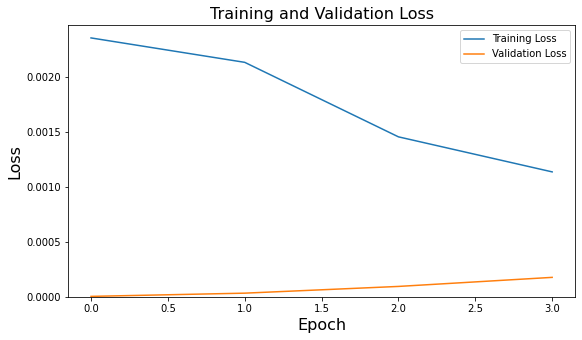

In [168]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize = 16)
plt.show()

### 5) Değerlendirme (Evaluation)

In [169]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

1/1 [==============================] - 0s 61ms/step - loss: 1.7659e-04

Test loss: 0.0%


In [170]:
train_predict = model.predict(X_train)

1/1 [==============================] - 0s 121ms/step


In [171]:
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 25ms/step


In [172]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [173]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [174]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [175]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [176]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 10.015670776367188
Test RMSE: 4.265716552734375


In [177]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [178]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [179]:
train_prediction_df = result_df[lookback:position]

In [1]:
train_prediction_df["Predicted"] = train_predict

In [110]:
train_prediction_df.head()

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


In [2]:
test_prediction_df = result_df[position + lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

In [3]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi

plt.figure(figsize=(14,5))
plt.plot(result_df, label = "Real Number of Passengers")
plt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color = "red", label = "Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

'\nplt.figure(figsize=(14,5))\nplt.plot(result_df, label = "Real Number of Passengers")\nplt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted Number of Passengers")\nplt.plot(test_prediction_df["Predicted"], color = "red", label = "Test Predicted Number of Passengers")\nplt.title("Number of Passengers Prediction")\nplt.xlabel("Time")\nplt.ylabel("Number of Passengers")\nplt.legend()\nplt.show()\n'